In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy.stats import skew

import re

from utils.utils import get_project_root

In [57]:
path_to_root = get_project_root()
# define data path
path_data = get_project_root() / "data"
# read dataset, exclude "NA" values from being parsed as np.NaN
df_train = pd.read_csv(path_data / "raw" / 'train.csv')
df_test = pd.read_csv(path_data / "raw" / 'test.csv')

In [58]:
df_grouped = pd.concat([df_train, df_test], ignore_index=True, sort=False)
# df_grouped.drop("Id", inplace=True, axis=1)
df_grouped

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


There are 37 numerical features and 43 object types. Among the numeric features, 25 are int and 12 are float.

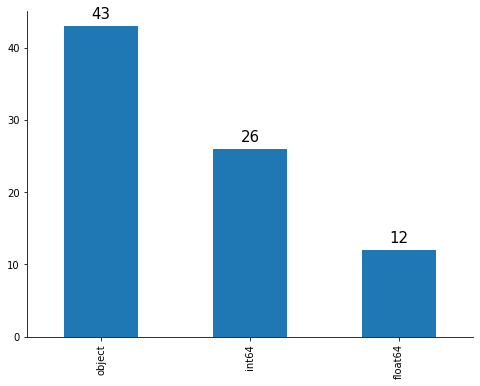

In [59]:
# show at types of data in dataset
plt.figure(figsize=(8, 6))
ax = df_grouped.dtypes.value_counts().plot(kind='bar')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, height, ha='center', size=15)
sns.despine()

Pulling out columns with missing values, we see that some features have a very large amount of missing data. This could be by design - a house without this feature has no entry, or by mistake - an error occured or the data was not provided, leaving this value blank.

For example, most houses probably don't have a pool, so they will have an empty value for `PoolQC`, whereas every house will have atleast *some* area connected to a street, so `LotFrontage` should never be empty.

In [60]:
features_sparse = df_grouped.columns[[i for i, x in enumerate(df_grouped.isnull().any()) if x]]
df_sparse = pd.DataFrame()
df_sparse["missing_initial"] = df_grouped[features_sparse].isnull().sum()
df_sparse["missing_initial_%"] = round(df_grouped.isnull().mean() * 100, 2)
df_sparse["total"] = df_grouped.shape[0]
df_sparse.sort_values(by="missing_initial_%", ascending=False)

,missing_initial,missing_initial_%,total
PoolQC,2909,99.66,2919
MiscFeature,2814,96.40,2919
Alley,2721,93.22,2919
Fence,2348,80.44,2919
SalePrice,1459,49.98,2919
FireplaceQu,1420,48.65,2919
LotFrontage,486,16.65,2919
GarageCond,159,5.45,2919
GarageYrBlt,159,5.45,2919
GarageFinish,159,5.45,2919


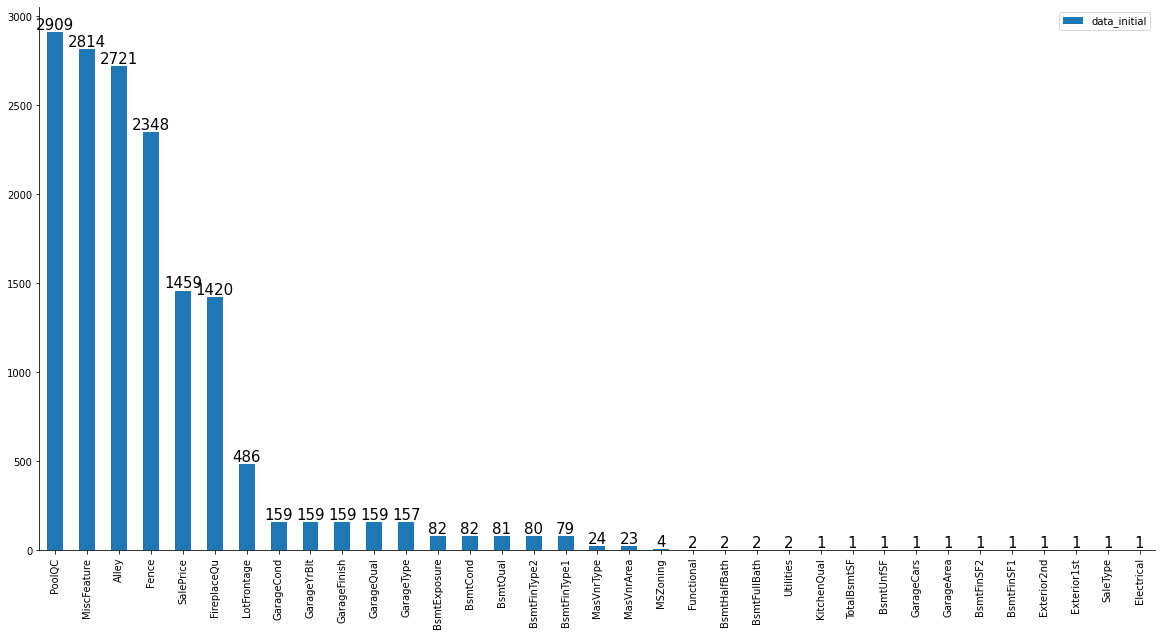

In [61]:
df_null = df_grouped.isnull().sum().to_frame(name="data_initial")
df_null[df_null > 0].dropna().sort_values(by="data_initial", ascending=False)
ax = df_null[df_null > 0].dropna().sort_values(by="data_initial", ascending=False).plot(kind='bar', figsize=(20, 10))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 15, int(height), ha='center', size=15)
sns.despine()

### Imputing numeric features
For erroneously empty values we can use imputation to estimate the value. This might amplify bias from our existing data, but provides more signal than dropping the data completely.
Note that this only works for training and validation data, because we have previous knowledge of these. During test time/ inference, all values have to be present, or an additional system to impute the missing values needs to be in place!

There are multiple ways to impute missing values, such as the average, mode and neural network solutions. We will use KNN for our numeric features, which should give good quality and is easily implemented using sklearn's KNNImputer.

We will apply this imputation method on all numerical categories, since those should never have empty values (except salePrice, since we want to predict that later).

In [62]:
# create imputer
imputer = KNNImputer()  # uses 5 by default, which we will stick to
# grab all numeric features
df_numeric = df_grouped.select_dtypes(include=["int", "float"])
df_numeric.drop("SalePrice", inplace=True, axis=1)
# impute
df_grouped[df_numeric.columns] = imputer.fit_transform(df_grouped[df_numeric.columns])

Looking at the missing values again, we can see that our numerical features now have no more missing values. Time to work on the categorical features!

In [63]:
df_sparse["missing_after_numeric_imputation"] = df_grouped[features_sparse].isnull().sum()
df_sparse["missing_after_numeric_imputation_%"] = round(df_grouped.isnull().mean() * 100, 2)
df_sparse.sort_values(by="missing_after_numeric_imputation_%", ascending=False, inplace=True)
df_sparse[["missing_initial_%", "missing_after_numeric_imputation_%"]].sort_values(
    by="missing_after_numeric_imputation_%")

,missing_initial_%,missing_after_numeric_imputation_%
GarageCars,0.03,0.00
GarageArea,0.03,0.00
BsmtFinSF1,0.03,0.00
LotFrontage,16.65,0.00
BsmtFullBath,0.07,0.00
MasVnrArea,0.79,0.00
GarageYrBlt,5.45,0.00
BsmtUnfSF,0.03,0.00
TotalBsmtSF,0.03,0.00
BsmtFinSF2,0.03,0.00


<AxesSubplot:>

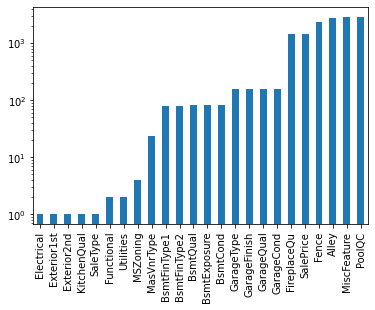

In [64]:
df_grouped.isnull().sum()[df_grouped.isnull().sum() > 0].sort_values().plot(kind="bar", logy=True)

### Imputing categorical features
categorical features are harder to impute, because we need to translate the categories (usually strings/objects) into numeric features. There are two types of categorical features:
- ordinal categories
- nominal categories

#### Ordinal categorical features
Ordinal categorical features are features that have implied meaning in their ordering. A rating between 0 and 5 symbolizes an ordering: 1 is better than 0, 2 > 1 etc.
The dataset uses different naming schemes for different ordinal categories, so we need to normalize this data and turn it into numerical values using the respective scale.

In [65]:
# since categories/ values represent better features, linear encoding is fine for this scale
# we use np.NaN instead of "NA", because pandas converts "NA" into NaN on import by default. We could disable this,
# but we chose to interpret NaNs as the string "NA" -> not existent in this context
# the standard scale for quality classification
std_scale = {np.NaN: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
category_encodings = {
    "GarageCond": std_scale,
    "GarageQual": std_scale,
    "BsmtCond": std_scale,
    "BsmtExposure": {np.NaN: 0, 'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 2},
    # similar to std_scale, but for basement finishing
    "BsmtFinType1": {np.NaN: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    "BsmtFinType2": {np.NaN: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    "BsmtQual": std_scale,
    "PoolQC": std_scale,
    "Alley": {np.NaN: 0, 'Grvl': 1, 'Pave': 2},  # gravel is worse than paved
    "FireplaceQu": std_scale,
    "ExterCond": std_scale,
    "ExterQual": std_scale,
    "KitchenQual": std_scale,
    "LandSlope": {'Sev': 1, 'Mod': 2, 'Gtl': 3},  # severe slope is much worse than gentle slope
    "PavedDrive": {'N': 1, 'P': 2, 'Y': 3},  # same with paved/unpaved
    # functionality of the house. salvage only should be penalized hard.
    "Functional": {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7},
    "HeatingQC": std_scale,
    "Street": {'Grvl': 1, 'Pave': 2},
    "Utilities": {'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},  # ELO = only electricity -> basically no utilities
    "MoSold": std_scale,
    # scores for suburb-classes to represent value (should be correct already?
    # "MSSubClass": {20: 'class1', 30: 'class2', 40: 'class3', 45: 'class4',
    #                50: 'class5', 60: 'class6', 70: 'class7', 75: 'class8',
    #                80: 'class9', 85: 'class10', 90: 'class11', 120: 'class12',
    #                150: 'class13', 160: 'class14', 180: 'class15', 190: 'class16'},

}
for k, v in category_encodings.items():
    if k in df_grouped and df_grouped[k].dtype == "object":
        df_grouped[k] = df_grouped[k].map(v)

Looking at a small sample, we can see that the previously categorical values are now numerical and we can continue with our nominal categories before doing imputation

In [66]:
df_grouped[["GarageCond", "GarageQual", "BsmtCond"]].sample(5)

,GarageCond,GarageQual,BsmtCond
114,3,3,3
1184,3,3,3
1758,3,3,3
2131,2,2,2
143,3,3,3


Many of the NaN values turned out to have meaning, and have dissapeared after our ordinal normalization

In [67]:
df_sparse["missing_after_ordinal_normalization"] = df_grouped[features_sparse].isnull().sum()
df_sparse["missing_after_ordinal_normalization_%"] = round(df_grouped.isnull().mean() * 100, 2)
df_sparse[
    ["missing_initial_%", "missing_after_numeric_imputation_%", "missing_after_ordinal_normalization_%"]].sort_values(
    by="missing_after_ordinal_normalization_%")

,missing_initial_%,missing_after_numeric_imputation_%,missing_after_ordinal_normalization_%
PoolQC,99.66,99.66,0.00
TotalBsmtSF,0.03,0.00,0.00
BsmtUnfSF,0.03,0.00,0.00
GarageYrBlt,5.45,0.00,0.00
BsmtFinSF2,0.03,0.00,0.00
BsmtFullBath,0.07,0.00,0.00
LotFrontage,16.65,0.00,0.00
BsmtFinSF1,0.03,0.00,0.00
MasVnrArea,0.79,0.00,0.00
GarageArea,0.03,0.00,0.00


<AxesSubplot:>

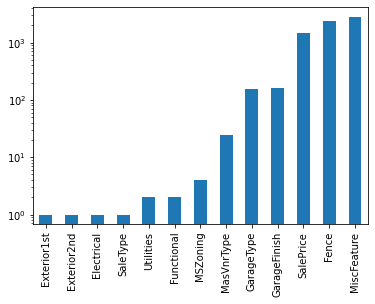

In [68]:
df_grouped.isnull().sum()[df_grouped.isnull().sum() > 0].sort_values().plot(kind="bar", logy=True)

#### Nominal categorical features
nominal categorical features are not ordered and provide no quantitative value. Our only option is to one-hot encode these features to keep their meaning.
One-hot encoding is a method where each category is added as a vector/column to the dataset. Datapoints/rows have `0` for categories that do not apply and `1` where it does. Since these categories are mutually exclusive, only one category is ever active; hence the name: one-hot.
For example, `LotShape` can be one of these values:

       LotShape: General shape of property
       Reg	Regular
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

encoding a datapoint with a regular shape would mean an encoding of `1,0,0,0` in the respective categorical columns.

In [69]:
df_grouped.select_dtypes(include=object)  # we already took care of ordinal categories, so all objects are nominal

,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,...,Foundation,Heating,CentralAir,Electrical,GarageType,GarageFinish,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,...,PConc,GasA,Y,SBrkr,Attchd,RFn,NaN,NaN,WD,Normal
1,RL,Reg,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,...,CBlock,GasA,Y,SBrkr,Attchd,RFn,NaN,NaN,WD,Normal
2,RL,IR1,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,...,PConc,GasA,Y,SBrkr,Attchd,RFn,NaN,NaN,WD,Normal
3,RL,IR1,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,...,BrkTil,GasA,Y,SBrkr,Detchd,Unf,NaN,NaN,WD,Abnorml
4,RL,IR1,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,...,PConc,GasA,Y,SBrkr,Attchd,RFn,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,Reg,Lvl,Inside,MeadowV,Norm,Norm,Twnhs,2Story,Gable,...,CBlock,GasA,Y,SBrkr,NaN,NaN,NaN,NaN,WD,Normal
2915,RM,Reg,Lvl,Inside,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,...,CBlock,GasA,Y,SBrkr,CarPort,Unf,NaN,NaN,WD,Abnorml
2916,RL,Reg,Lvl,Inside,Mitchel,Norm,Norm,1Fam,1Story,Gable,...,CBlock,GasA,Y,SBrkr,Detchd,Unf,NaN,NaN,WD,Abnorml
2917,RL,Reg,Lvl,Inside,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,...,PConc,GasA,Y,SBrkr,NaN,NaN,MnPrv,Shed,WD,Normal


#### Temporal Values
There is one more type of values in our dataset: temporal features.
Temporal features, like day, month and year are discrete, nominal values. This means we have to convert them into a more suitable format. If we don't do this, values like `month` will be treated as an ordinal, numeric value, and december (12) would be better than january (1).

For cyclical values like day and month this is no problem, because we have a limited number of categories. Values with high variability like `year` on the other hand, are a bigger problem. Depending on the timeframe of our dataset, a single `year` feature could result in 2000 one-hot features!

For this reason, we will keep our year values as ordinal values and will only encode month. Out of interest, lets analyze our temporal features anyway:

In [70]:
[(x, df_grouped[x].min(), df_grouped[x].max(), df_grouped[x].max() - df_grouped[x].min()) for x in df_grouped.columns if
 re.search("Yr|year", x, flags=re.I)]

[('YearBuilt', 1872.0, 2010.0, 138.0),
 ('YearRemodAdd', 1950.0, 2010.0, 60.0),
 ('GarageYrBlt', 1895.0, 2207.0, 312.0),
 ('YrSold', 2006.0, 2010.0, 4.0)]

We would potentially need 314 additional one-hot features to encode these four features!
An error in the data also surfaced, with `GarageYrBlt` apparently being built in the future (2207 should probably be 2007)!
We will have to handle this in our outlier analysis. First lets encode our categorical nominal values!

Note, There is another issue! Our test dataset has some categories that are not present in the training set. This is a bit awkward, because in the real world we would not be looking at the test set!

But this "test" set is in truth really our validation set, because we are optimizing on it before using the hidden kaggle test set to submit our answer. This is the reason why we combined training and test set at the beginning, doing data-wrangling on both sets.

Anyway, lets look at our nominal categories:

In [71]:
categoricals = df_grouped.select_dtypes(include=object).columns.tolist() + ["MoSold"]
print(categoricals)
# df_xc_ohe = pd.get_dummies(df_xc, columns=.columns, drop_first=True)

['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MoSold']


Looking at the empty values in these categories and comparing them to the `data_description.txt`, we see that some of these values have `NaN` values, which are actually encoded and some have `NaN` values when they shouldn't - namely:
`Exterior1st, Exterior2nd, Electrical, SaleType, MSZoning`

In [72]:
null = df_grouped[categoricals].isnull().sum()
null[null > 0].sort_values()

Exterior1st        1
Exterior2nd        1
Electrical         1
SaleType           1
MSZoning           4
MasVnrType        24
GarageType       157
GarageFinish     159
Fence           2348
MiscFeature     2814
dtype: int64

Lets impute these missing values. We can't use the KNNImputer as before, because it only works with numerical values. But we can use the mode - the value that appears most often. Since there are only a few missing values, this should be fine.

In [73]:
for x in null[(null > 0) & (null < 20)].index.tolist():
    df_grouped[x].fillna(df_grouped[x].mode()[0], inplace=True)

In [74]:
null = df_grouped[categoricals].isnull().sum()
null[null > 0].sort_values()

MasVnrType        24
GarageType       157
GarageFinish     159
Fence           2348
MiscFeature     2814
dtype: int64

lets finally get to one-hot encoding - with `pd.get_dummies`. We can drop the first value, because the data is implicitly added (the first category = all 0's), saving us one feature vector.

Note that if we knew more about the data, we could encode some of these nominal values as ordinal values. For example, if we knew which neighborhood was good, or which garage type is more expensive, we could order these. But we don't, so we won't ;)

In [75]:
df_grouped = pd.get_dummies(df_grouped, columns=categoricals, drop_first=True)
df_grouped.sample(3)

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,Utilities,LandSlope,OverallQual,OverallCond,...,MoSold_3.0,MoSold_4.0,MoSold_5.0,MoSold_6.0,MoSold_7.0,MoSold_8.0,MoSold_9.0,MoSold_10.0,MoSold_11.0,MoSold_12.0
2323,2324.0,80.0,87.0,11084.0,2,0,3.0,3,7.0,5.0,...,0,0,0,1,0,0,0,0,0,0
1481,1482.0,120.0,41.0,7132.0,2,0,3.0,3,8.0,5.0,...,0,1,0,0,0,0,0,0,0,0
1472,1473.0,160.0,21.0,1680.0,2,0,3.0,3,5.0,5.0,...,1,0,0,0,0,0,0,0,0,0


Great, we are down to two categories with missing values. Utilites and functional both should not have `NaN` values, so there must be real missing data. We turned these columns into numerical categories earlier, so we can use the KNNImputer again to fill these values.

<AxesSubplot:>

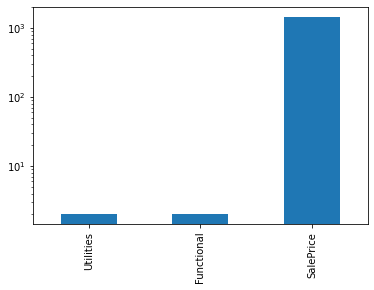

In [76]:
df_grouped.isnull().sum()[df_grouped.isnull().sum() > 0].sort_values().plot(kind="bar", logy=True)

In [77]:
df_grouped[["Utilities", "Functional"]] = imputer.fit_transform(df_grouped[["Utilities", "Functional"]])

And we are left with empty values in just the salePrice, which we want to fit models to predict on.

<AxesSubplot:>

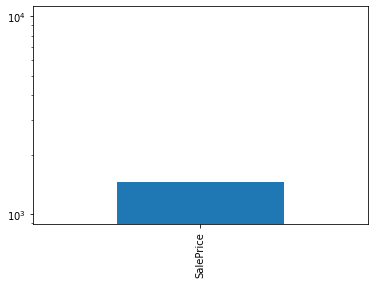

In [78]:
df_grouped.isnull().sum()[df_grouped.isnull().sum() > 0].sort_values().plot(kind="bar", logy=True)

Before continuing, lets save the dataset. We can later use multiple versions to see which feature-engineering helped us improve our results.

In [79]:
hdf = get_project_root() / "data/formatted/dataset_clean.h5"  # define the path to the database
# split the dataset
df_train_clean = df_grouped[: df_train.shape[0]]
df_test_clean = df_grouped[df_train.shape[0]:]
# split x and y for training
x_train_clean = df_train_clean[df_train_clean.columns.difference(["SalePrice"])]
y_train_clean = df_train_clean["SalePrice"]
x_train_clean.to_hdf(hdf, key="x_train")
y_train_clean.to_hdf(hdf, key="y_train")
df_test_clean.drop(["SalePrice"], axis="columns").to_hdf(hdf, key="x_test")

we should look at outlier values in our dataset that could potentially skew our detection. In general, neural networks should be able to handle single outliers, but if we do normalization on data these outliers could skew the results (like our garage built in 2207 from before).

Looking at the box plots and their outlier markers, we can see a few large outliers. Some of these are categorical features, which we have turned into numerical ones, and some represent ordinal values by themselves. For these we don't need to do anything, because the scale is fixed.

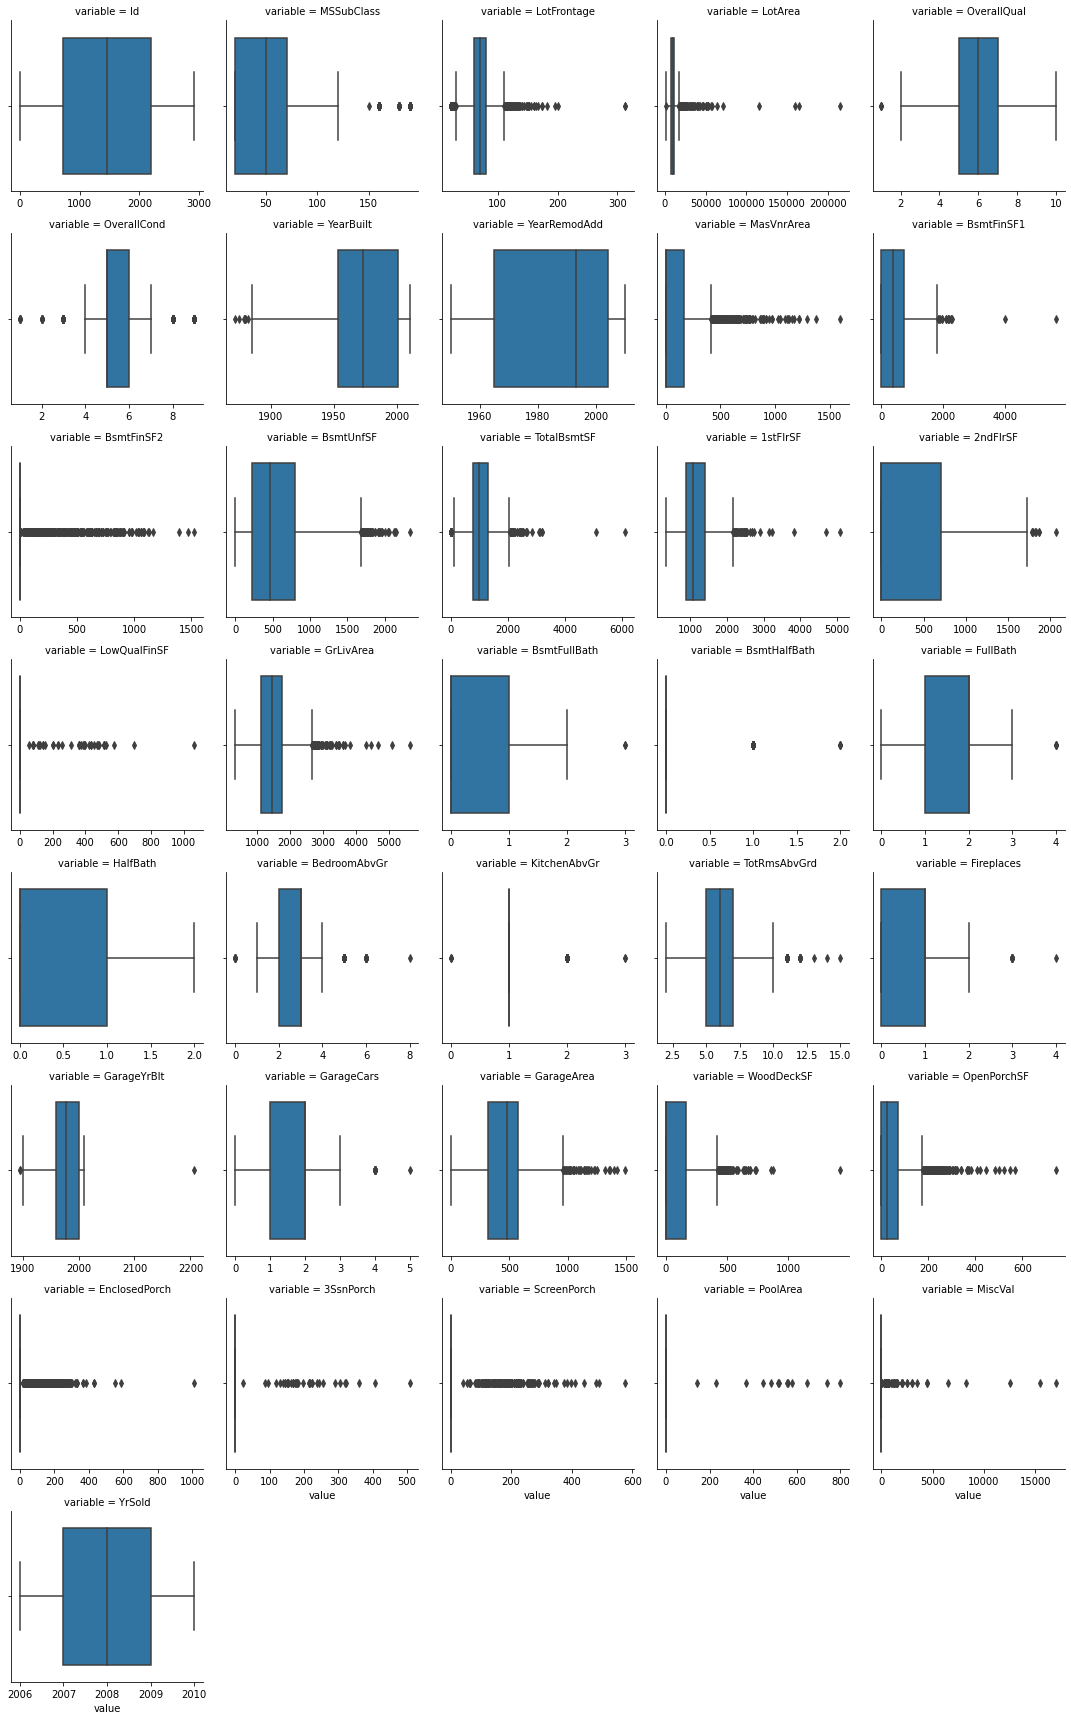

In [80]:
# visualize the distribution of each numerical feature. Remember to remove MoSold, since we turned that into a category
features_numeric = df_numeric.drop("MoSold", axis="columns").columns
temp = pd.melt(df_grouped, value_vars=df_grouped[features_numeric])
grid = sns.FacetGrid(temp, col="variable", col_wrap=5, size=3.0,
                     aspect=1.0, sharex=False, sharey=False)
grid.map(sns.boxplot, "value")
plt.show()

Taking a closer look at the biggest outliers, we can see a few datapoints having massive sizes. Do these outliers have an accordingly large impact on the salePrice - our target?
Most outliers, like `LotFrontage`, `BsmtFinSF1` or `1stFlrSF` do not have a large impact at all.

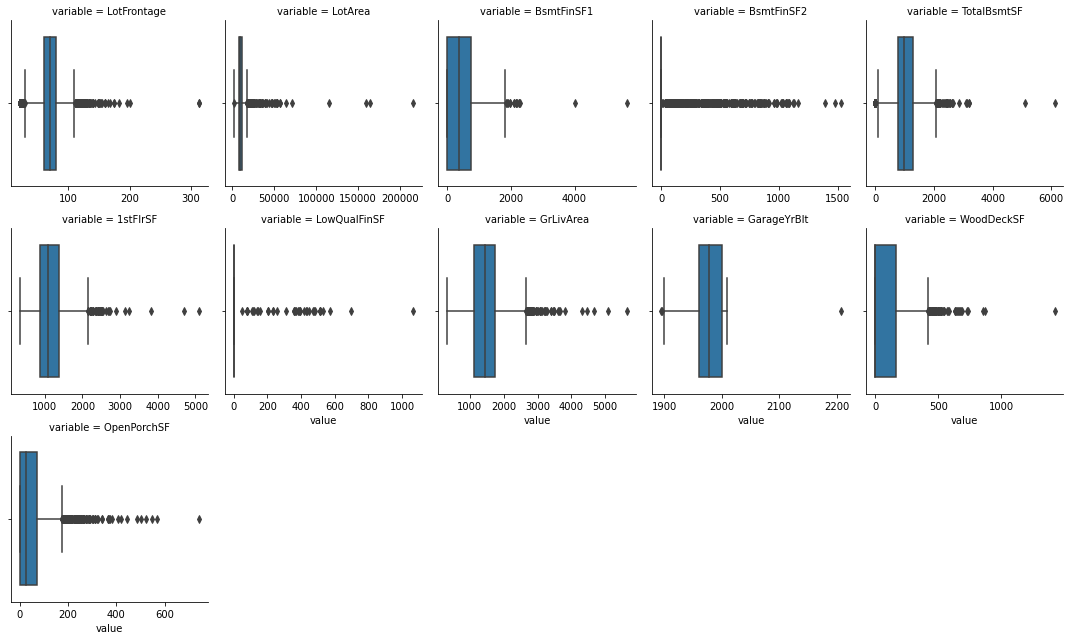

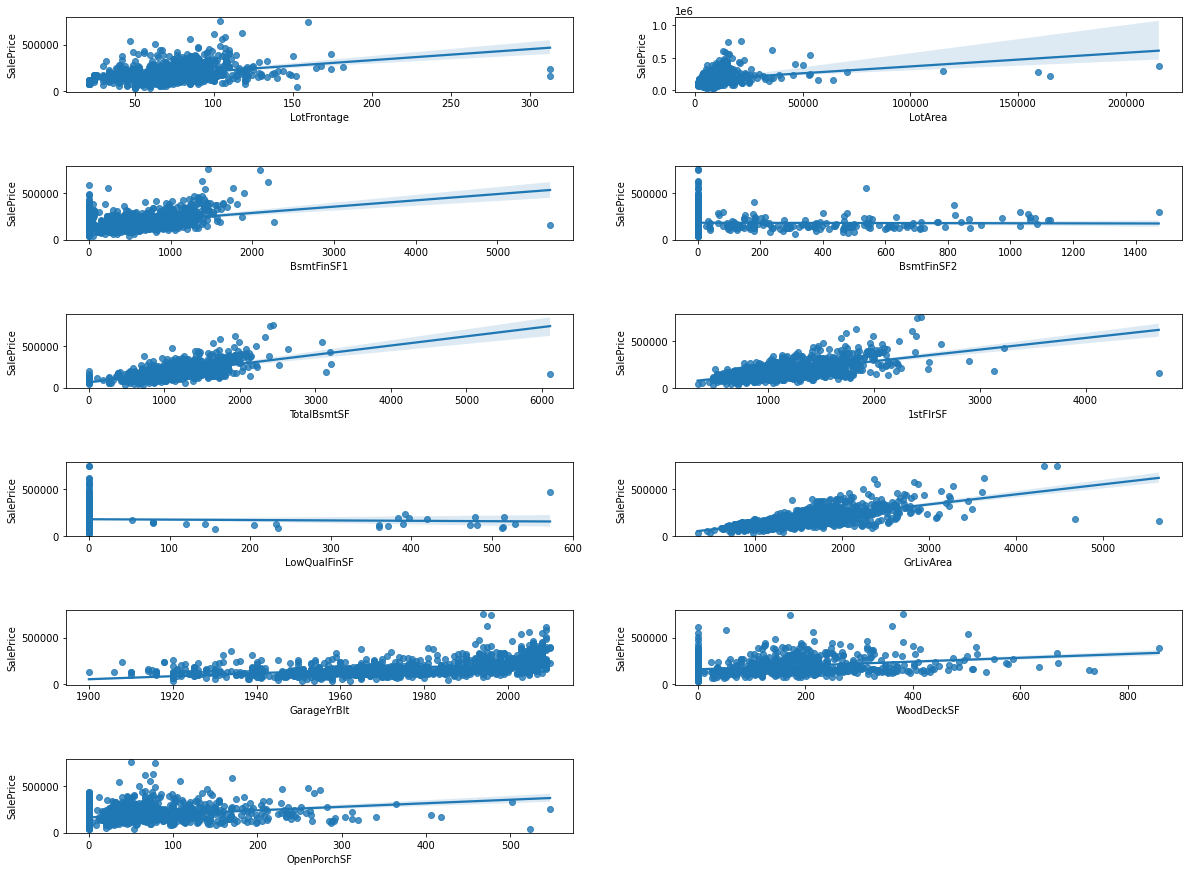

In [81]:
feature_outliers = ["LotFrontage", "LotArea", "BsmtFinSF1", "BsmtFinSF2", "TotalBsmtSF", "1stFlrSF", "LowQualFinSF",
                    "GrLivArea", "GarageYrBlt", "WoodDeckSF", "OpenPorchSF"]
temp = pd.melt(df_grouped, value_vars=df_grouped[feature_outliers])
grid = sns.FacetGrid(temp, col="variable", col_wrap=5, size=3.0,
                     aspect=1.0, sharex=False, sharey=False)
grid.map(sns.boxplot, "value")
plt.show()
i = 1
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=1)
for feature in feature_outliers:
    plt.subplot(6, 2, i)
    sns.regplot(data=df_grouped, x=feature, y='SalePrice')
    i += 1

Since These are very few datapoints which could negatively impact our regression, we will cap these values to a maximum value. Alternatively we could drop all rows with outliers.

In [82]:
max_vals = {"LotFrontage": 200,
            "LotArea": 10000,
            "BsmtFinSF1": 2000,
            "BsmtFinSF2": 1200,
            "TotalBsmtSF": 3500,
            "1stFlrSF": 3000,
            "LowQualFinSF": 550,
            "GrLivArea": 4000,
            "GarageYrBlt": 2020,
            "WoodDeckSF": 650,
            "OpenPorchSF": 400
            }
for key, val in max_vals.items():
    df_grouped[key].loc[df_grouped[key] > val] = val

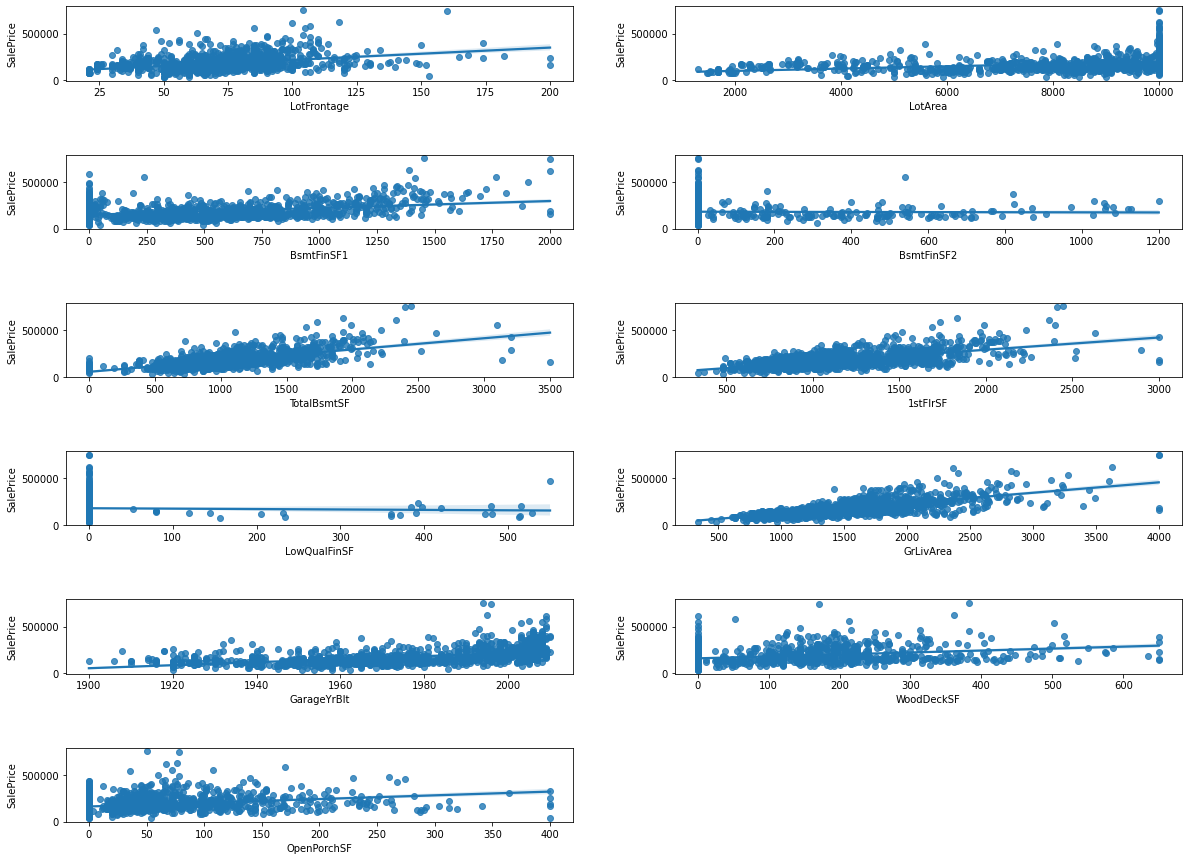

In [83]:
i = 1
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=1)
for feature in feature_outliers:
    plt.subplot(6, 2, i)
    sns.regplot(data=df_grouped, x=feature, y='SalePrice')
    i += 1

Lets save the data again, before going on to scaling

In [84]:
df_train_clean = df_grouped[: df_train.shape[0]]
df_test_clean = df_grouped[df_train.shape[0]:]
# split x and y for training
x_train_clean = df_grouped[df_grouped.columns.difference(["SalePrice"])]
y_train_clean = df_grouped["SalePrice"]
x_train_clean.to_hdf(hdf, key="x_train_no_outliers")
y_train_clean.to_hdf(hdf, key="y_train_no_outliers")
df_test_clean.drop(["SalePrice"], axis="columns").to_hdf(hdf, key="x_test_deskewed")

### Scaling
The last step we will take is scaling our numerical features. We will scale highly skewed features using a log scale to reduce skewedness and normalize the distance between the values.

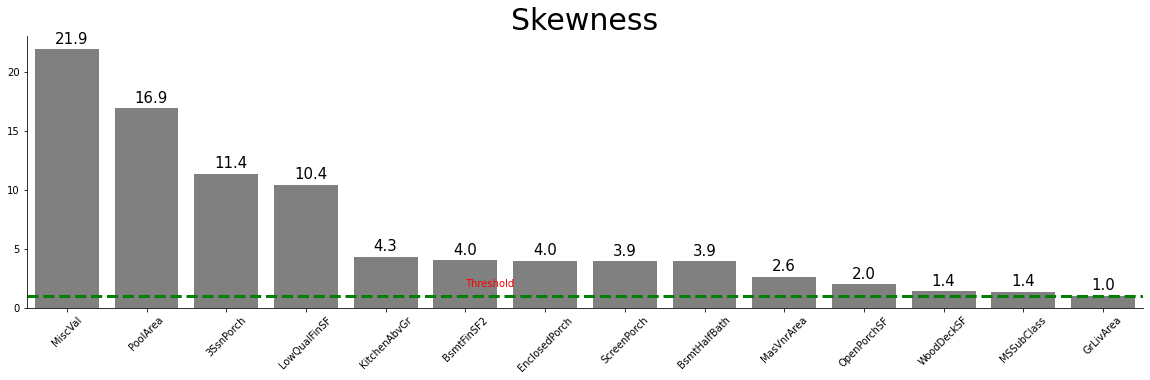

In [85]:
plt.figure(figsize=(20, 5))
features_skewed = df_grouped[features_numeric].apply(lambda x: skew(x))
features_skewed = features_skewed[features_skewed > 1].sort_values(ascending=False)
ax = sns.barplot(x=features_skewed.index, y=features_skewed.values, color='grey')
for p in ax.patches:
    height = p.get_height().round(1)
    ax.text(p.get_x() + 0.25, height + 0.5, height, ha='left', size=15)
plt.xticks(rotation=45)
plt.text(5, 1.75, 'Threshold', color='red')
plt.axhline(y=1, color='green', linestyle='--', linewidth=3)
plt.title('Skewness', fontsize=30)
sns.despine()

In [86]:
df_grouped[features_skewed.index] = np.log1p(df_grouped[features_skewed.index])

We can see that the Skewedness decreased greatly, from 14 above the threshold to 9 above.

5


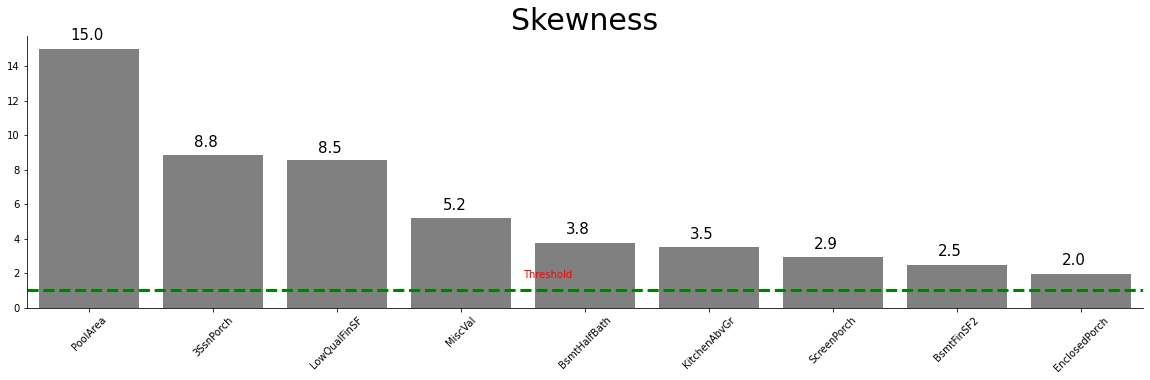

In [87]:
plt.figure(figsize=(20, 5))
features_skewed = df_grouped[features_numeric].apply(lambda x: skew(x))
features_skewed = features_skewed[features_skewed > 1].sort_values(ascending=False)
ax = sns.barplot(x=features_skewed.index, y=features_skewed.values, color='grey')
for p in ax.patches:
    height = p.get_height().round(1)
    ax.text(p.get_x() + 0.25, height + 0.5, height, ha='left', size=15)
plt.xticks(rotation=45)
plt.text(round(len(ax.patches) / 2) - 0.5, 1.75, 'Threshold', color='red')
print(round(len(ax.patches) / 2) + 1)
plt.axhline(y=1, color='green', linestyle='--', linewidth=3)
plt.title('Skewness', fontsize=30)
sns.despine()

Looking more closely at the leftover skewed features, we can see that further data engineering won't be able to improve skewedness, so we will stick with this.

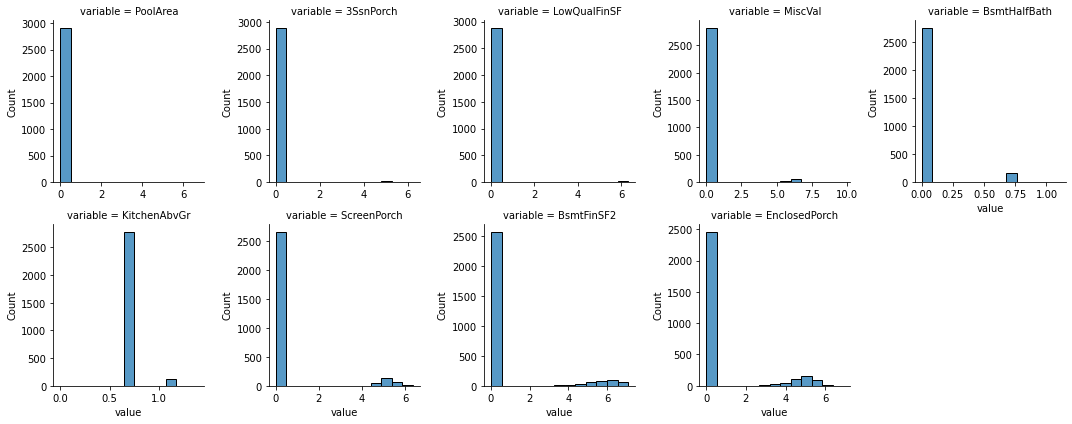

In [88]:
temp = pd.melt(df_grouped, value_vars=df_grouped[features_skewed.index])
grid = sns.FacetGrid(temp, col="variable", col_wrap=5, size=3.0,
                     aspect=1.0, sharex=False, sharey=False)
grid.map(sns.histplot, "value")
plt.show()

In [89]:
df_train_clean = df_grouped[: df_train.shape[0]]
df_test_clean = df_grouped[df_train.shape[0]:]
# split x and y for training
x_train_clean = df_train_clean[df_train_clean.columns.difference(["SalePrice"])]
y_train_clean = df_train_clean["SalePrice"]
x_train_clean.to_hdf(hdf, key="x_train_deskewed")
y_train_clean.to_hdf(hdf, key="y_train_deskewed")
df_test_clean.drop(["SalePrice"], axis="columns").to_hdf(hdf, key="x_test_deskewed")